In [1]:
using CSV
using DataFrames
using Turing
using Logging
using StatisticalRethinking
using StatsBase
using StatsPlots

using Dagitty

default(label=false)
Logging.disable_logging(Logging.Warn);

# 5.1 Spurious association

Code 5.1

In [2]:
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage);

Code 5.2

In [3]:
std(d.MedianAgeMarriage)

1.2436303013880823

Code 5.3

In [4]:
Random.seed!(100)

@model function model_m5_1(A, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    μ = @. a + bA * A
    D ~ MvNormal(μ, σ)
end

m5_1 = sample(model_m5_1(d.A, d.D), NUTS(), 1000)
m5_1_df = DataFrame(m5_1)
prior = sample(model_m5_1([0], [0]), Prior(), 1000)
prior_df = DataFrame(prior);

Code 5.4

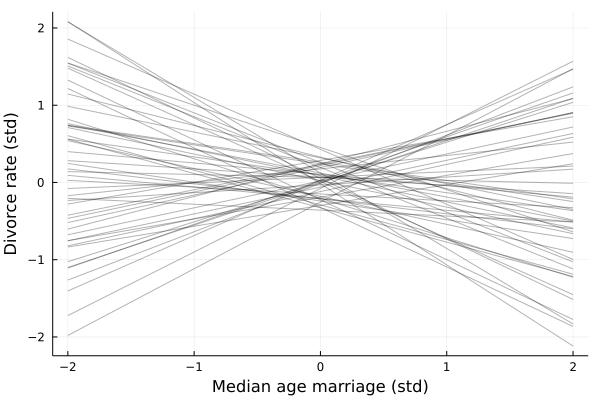

In [5]:
# calculate μ for every prior sample on age=-2 and age=2
bounds = [-2, 2]
μ = StatisticalRethinking.link(prior_df, [:a, :bA], bounds)
μ = hcat(μ...);

p = plot(xlab="Median age marriage (std)", ylab="Divorce rate (std)")
for μₚ ∈ first(eachrow(μ), 50)
    plot!(bounds, μₚ; c=:black, alpha=0.3)
end
display(p)

Code 5.5

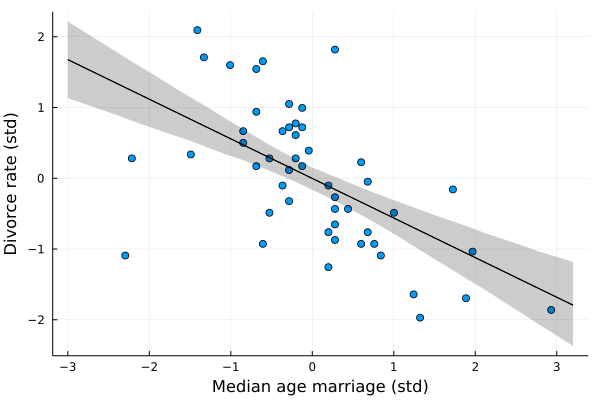

In [6]:
A_seq = range(-3, 3.2; length=30)

μ = StatisticalRethinking.link(m5_1_df, [:a, :bA], A_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df d scatter(:A, :D; xlab="Median age marriage (std)", ylab="Divorce rate (std)")
plot!(A_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

Code 5.6

In [7]:
Random.seed!(100)

@model function model_m5_2(M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    μ = @. a + bM * M
    D ~ MvNormal(μ, σ)
end

m5_2 = sample(model_m5_2(d.M, d.D), NUTS(), 1000)
m5_2_df = DataFrame(m5_2);

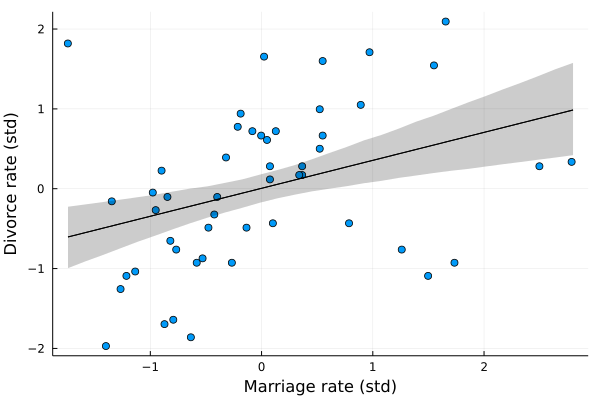

In [8]:
M_seq = range(-1.74, 2.8; length=30)

μ = StatisticalRethinking.link(m5_2_df, [:a, :bM], M_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df d scatter(:M, :D; xlab="Marriage rate (std)", ylab="Divorce rate (std)")
plot!(M_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

Code 5.7

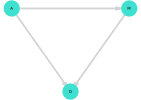

In [9]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
drawdag(g, [0, 1, 2], [0, 1, 0])

Code 5.8: TODO

Code 5.9: TODO

Code 5.10

In [10]:
@model function model_m5_3(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
end

m5_3 = sample(model_m5_3(d.A, d.M, d.D), NUTS(), 1000)
m5_3_df = DataFrame(m5_3)
precis(m5_3_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     σ │  0.8329   0.084   0.7067   0.8262   0.9761   ▁▂▅██▇▄▂▁▁▁▁ │
│     a │ -0.0045  0.0995  -0.1716    0.001   0.1461       ▁▁▄██▃▁▁ │
│    bA │  -0.609  0.1655  -0.8759  -0.6072  -0.3387   ▁▁▁▁▃▆██▅▃▁▁ │
│    bM │ -0.0665  0.1712  -0.3249  -0.0743    0.208  ▁▁▁▁▂▅██▆▄▂▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 5.11

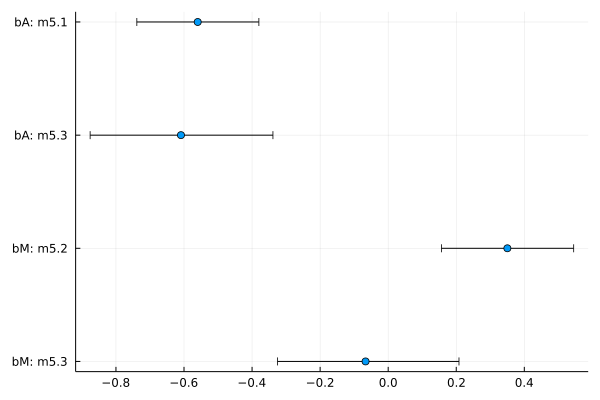

In [11]:
coeftab_plot(m5_1_df, m5_2_df, m5_3_df; pars=(:bA, :bM), names=["m5.1", "m5.2", "m5.3"])

Code 5.12

In [12]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age));

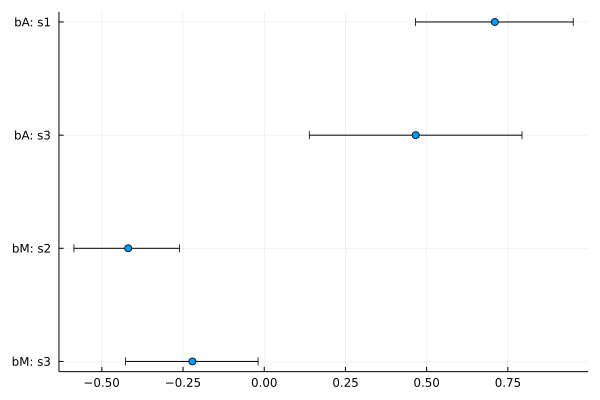

In [13]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

In [14]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age .+ mar));

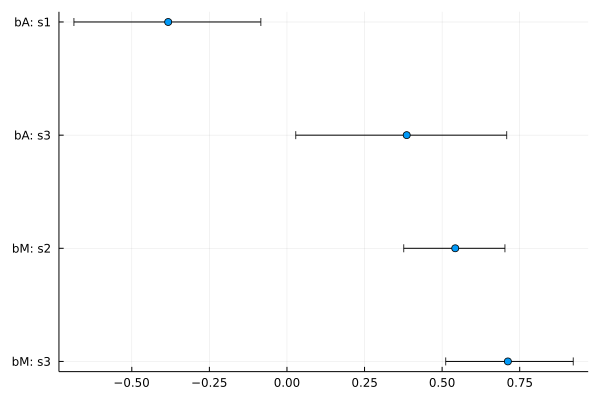

In [15]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

Code 5.13

In [16]:
Random.seed!(100)

@model function model_m5_4(A, M)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ = @. a + bAM * A
    M ~ MvNormal(μ, σ)
end

m5_4 = sample(model_m5_4(d.A, d.M), NUTS(), 1000)
m5_4_df = DataFrame(m5_4);

Code 5.14

In [17]:
mu = StatisticalRethinking.link(m5_4_df, [:a, :bAM], d.A);
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_resid = mu_mean .- d.M;

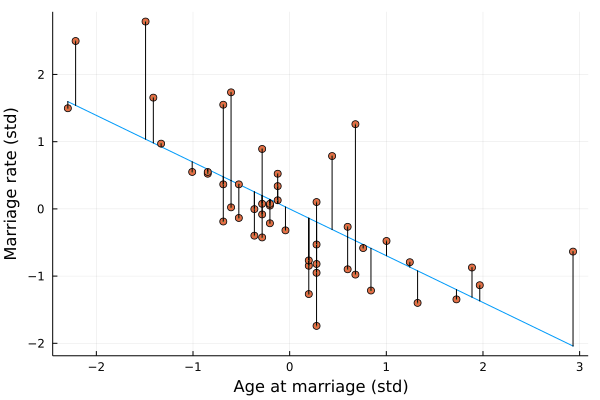

In [18]:
# Side-note: how to plot the residuals
# getting yerr - list of 2-tuples with distance to the regression line
yerr = collect(zip(-clamp.(mu_resid, -Inf, -0.0), clamp.(mu_resid, 0, Inf)));

plot(d.A, mu_mean; xlab="Age at marriage (std)", ylab="Marriage rate (std)")
scatter!(d.A, d.M)
scatter!(d.A, d.M; yerr=yerr, markersize=0)

Code 5.15

In [19]:
# explicit link form before I improved it
mu = [
    @. r.a + r.bA * d.A + r.bM * d.M
    for r ∈ eachrow(m5_3_df)
]

mu = vcat(mu'...)
mu_mean = mean.(eachcol(mu))
mu_PI = PI.(eachcol(mu))
mu_PI = vcat(mu_PI'...);

D_sim = [
    rand(MvNormal((@. r.a + r.bA * d.A + r.bM * d.M), r.σ))
    for r ∈ eachrow(m5_3_df)
]
D_sim = vcat(D_sim'...);
D_PI = PI.(eachcol(D_sim))
D_PI = vcat(D_PI'...);

Code 5.16

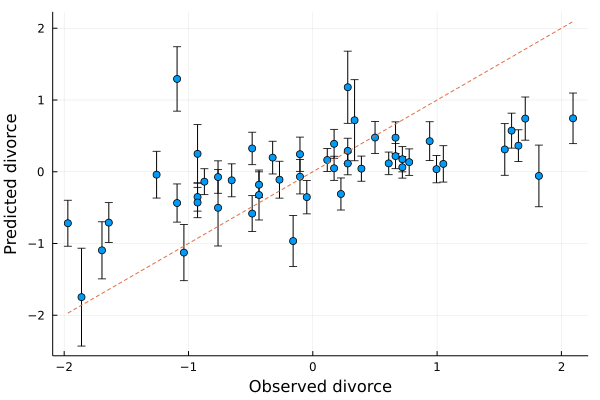

In [20]:
yerr = mu_PI[:,2] .- mu_mean
scatter(d.D, mu_mean; xlab="Observed divorce", ylab="Predicted divorce", yerr=yerr)
plot!(x->x; style=:dash)

Code 5.17

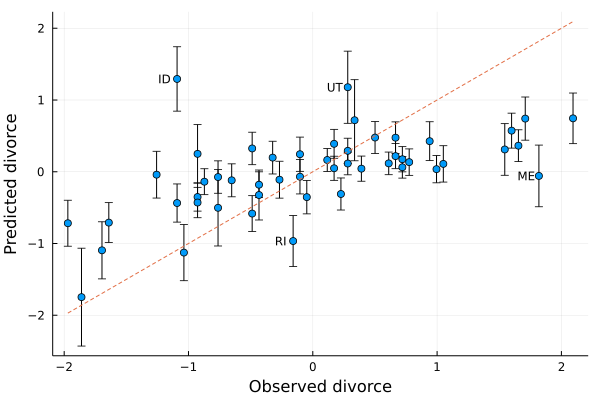

In [21]:
loc_flags = d.Loc .∈ (["ID", "UT", "RI", "ME"],);
loc_idxes = findall(loc_flags);
anns = [
    (d.D[idx] - 0.1, mu_mean[idx], (d.Loc[idx], 8))
    for idx in loc_idxes
]
annotate!(anns)

Code 5.18

In [22]:
Random.seed!(100)
N = 100
x_real = rand(Normal(), N)
x_spur = rand.(Normal.(x_real))
y = rand.(Normal.(x_real))
df = DataFrame(:y => y, :x_real => x_real, :x_spur => x_spur);

Code 5.19

In [25]:
d1 = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d = DataFrame(
    :D => standardize(ZScoreTransform, d1.Divorce),
    :M => standardize(ZScoreTransform, d1.Marriage),
    :A => standardize(ZScoreTransform, d1.MedianAgeMarriage),
);

@model function model_m5_3A(A, M, D)
    # A → D ← M
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
    # A → M
    σ_M ~ Exponential(1)
    aM ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ_M = @. aM + bAM * A
    M ~ MvNormal(μ_M, σ_M)
end

m5_3A = sample(model_m5_3A(d.A, d.M, d.D), NUTS(), 1000)
m5_3A_df = DataFrame(m5_3A)
precis(m5_3A_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     σ │  0.8281  0.0863   0.7022   0.8169   0.9705   ▁▂▅██▆▄▃▁▁▁▁ │
│     a │  -0.001  0.0981  -0.1544      0.0   0.1575        ▁▁▄██▃▁ │
│    bA │ -0.6081  0.1551  -0.8466  -0.6053  -0.3529   ▁▁▃▇██▆▃▁▁▁▁ │
│    bM │ -0.0592  0.1566  -0.3145  -0.0546   0.1787  ▁▁▂▄▇█▇▄▂▁▁▁▁ │
│   σ_M │  0.7105  0.0725   0.6029   0.7058   0.8322      ▁▂▅██▅▃▁▁ │
│    aM │    -0.0  0.0885  -0.1377  -0.0006   0.1482   ▁▁▂▄▆██▆▄▂▁▁ │
│   bAM │ -0.6942  0.0995  -0.8448  -0.6965  -0.5363      ▁▁▃██▄▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 5.20

In [26]:
A_seq = range(-2, 2; length=30);

Code 5.21

In [27]:
s_M, s_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * A_seq), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * A_seq + r.bM * M), r.σ))
    push!(s_M, M)
    push!(s_D, D)
end

s_M = vcat(s_M'...)
s_D = vcat(s_D'...);

Code 5.22

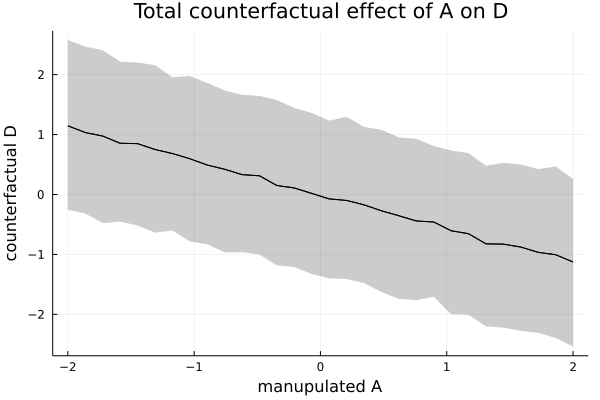

In [29]:
μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)

plot(
    A_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated A", ylab="counterfactual D",
    title="Total counterfactual effect of A on D"
)

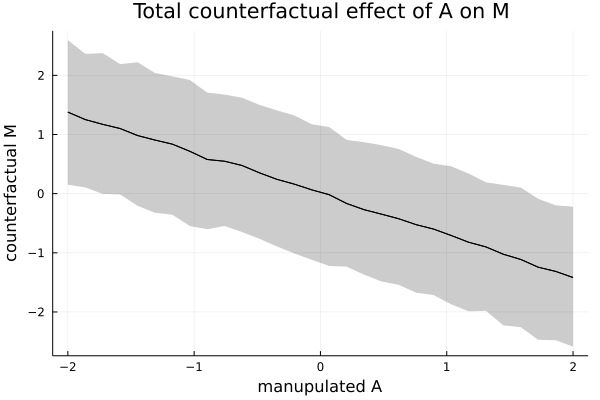

In [30]:
μ_M = mean.(eachcol(s_M))
PI_M = vcat(PI.(eachcol(s_M))'...)

plot(
    A_seq, [μ_M, μ_M]; 
    fillrange=PI_M, fillalpha=0.2, color=:black,
    xlab="manupulated A", ylab="counterfactual M",
    title="Total counterfactual effect of A on M"
)

Code 5.23

In [33]:
sim2_A = @. ([20, 30] - 26.1) / 1.24;
s2_M, s2_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * sim2_A), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * sim2_A + r.bM * M), r.σ))
    push!(s2_M, M)
    push!(s2_D, D)
end

s2_M = vcat(s2_M'...)
s2_D = vcat(s2_D'...);
mean(s2_D[:,2] - s2_D[:,1])

-4.6032269038425895

Code 5.24

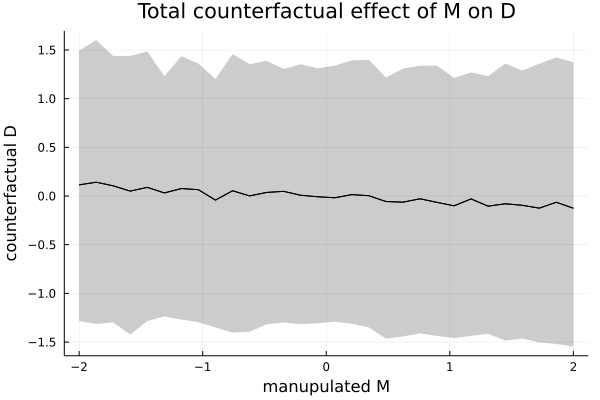

In [34]:
M_seq = range(-2, 2; length=30)
s_D = []

for r ∈ eachrow(m5_3A_df)
    # A is zero, so, we drop it from the μ term
    D = rand(MvNormal((@. r.a + r.bM * M_seq), r.σ))
    push!(s_D, D)
end

s_D = vcat(s_D'...);

μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)

plot(
    M_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated M", ylab="counterfactual D",
    title="Total counterfactual effect of M on D"
)

Code 5.25

In [35]:
A_seq = range(-2, 2; length=30);

Code 5.26

In [36]:
s_M = [
    rand(MvNormal((@. r.aM + r.bAM * A_seq), r.σ_M))
    for r ∈ eachrow(m5_3A_df)
]
s_M = vcat(s_M'...);

Code 5.27

In [39]:
s_D = [
    rand(MvNormal((@. r.a + r.bA * A_seq + r.bM * M), r.σ))
    for (r, M) ∈ zip(eachrow(m5_3A_df), eachrow(s_M))
]
s_D = vcat(s_D'...);

# 5.2 Masked relationship